In [18]:
# Stock Forecasting — Clean, Robust, and Reproducible
# Requirements: yfinance pandas numpy matplotlib seaborn scikit-learn xgboost shap tensorflow
# pip install yfinance pandas numpy matplotlib seaborn scikit-learn xgboost shap tensorflow

# ----Imports & Config----

# Requires: yfinance, pandas, numpy, matplotlib, seaborn, scikit-learn, xgboost, shap, tensorflow
# pip install yfinance pandas numpy matplotlib seaborn scikit-learn xgboost shap tensorflow

import warnings
warnings.filterwarnings("ignore")

import datetime
import os
import yfinance as yf
import pandas as pd
import numpy as np, random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# For explainability
import shap

# For LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [19]:
# -------------------------------
# Utility / helpers
# -------------------------------
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

def directional_accuracy(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    true_dir = np.sign(pd.Series(y_true).diff().dropna()).values
    pred_dir = np.sign(pd.Series(y_pred).diff().dropna()).values
    m = min(len(true_dir), len(pred_dir))
    if m == 0:
        return np.nan
    return np.mean(true_dir[:m] == pred_dir[:m])

def sharpe_ratio(returns, risk_free=0.0):
    if returns.std() == 0:
        return np.nan
    return (returns.mean() - risk_free) / (returns.std() + 1e-12)

def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

# create output folder
OUT_DIR = "forecast_output"
os.makedirs(OUT_DIR, exist_ok=True)


In [20]:
# -------------------------------
# 0. Inputs & Download
# -------------------------------
stock_symbol = input("Enter Stock Symbol (e.g. AAPL, MSFT, TSLA): ").upper().strip() or "AAPL"
start_date = input("Enter Start Date (YYYY-MM-DD) [default: 2020-01-01]: ").strip() or "2020-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d")

print(f"\nDownloading {stock_symbol} data from {start_date} to {end_date} ...")
data = yf.download(stock_symbol, start=start_date, end=end_date)

if data.empty:
    raise SystemExit("No data returned. Check symbol or dates and re-run.")

data = data.rename(columns=lambda x: x.strip())


Enter Stock Symbol (e.g. AAPL, MSFT, TSLA): 
Enter Start Date (YYYY-MM-DD) [default: 2020-01-01]: 


[*********************100%***********************]  1 of 1 completed


=== DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1423 entries, 2020-01-02 to 2025-08-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1423 non-null   float64
 1   (High, AAPL)    1423 non-null   float64
 2   (Low, AAPL)     1423 non-null   float64
 3   (Open, AAPL)    1423 non-null   float64
 4   (Volume, AAPL)  1423 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 66.7 KB
None

=== MISSING VALUES ===
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

=== SUMMARY STATISTICS ===
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1423.000000  1423.000000  1423.000000  1423.000000  1.423000e+03
mean     159.304504   160.955737   157.484669   159.145185  8.666022e+07
std       44.8

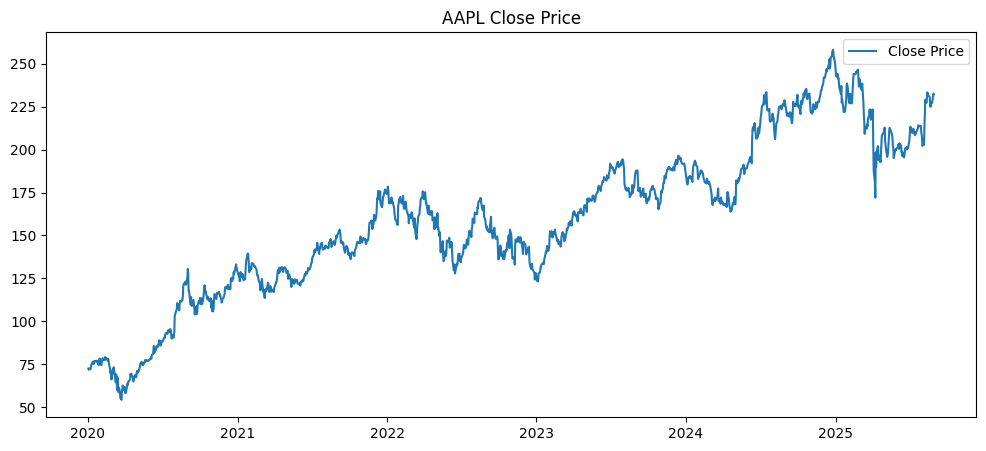

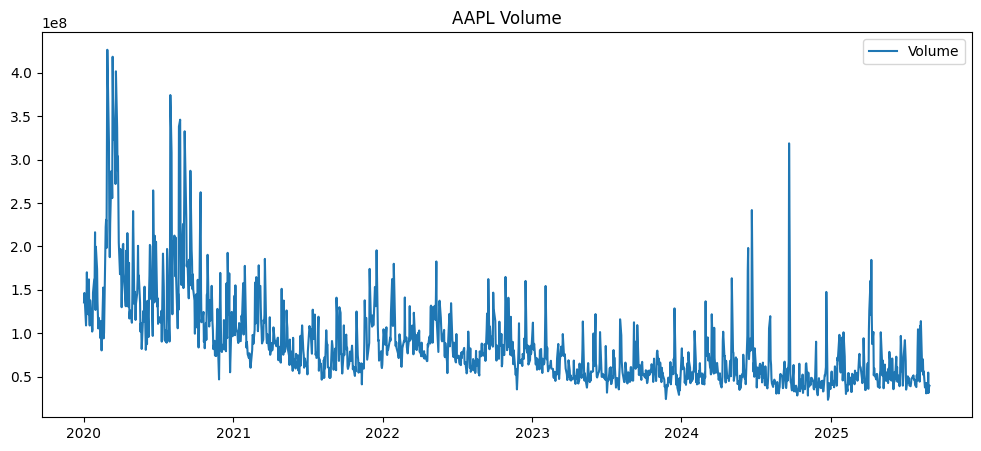

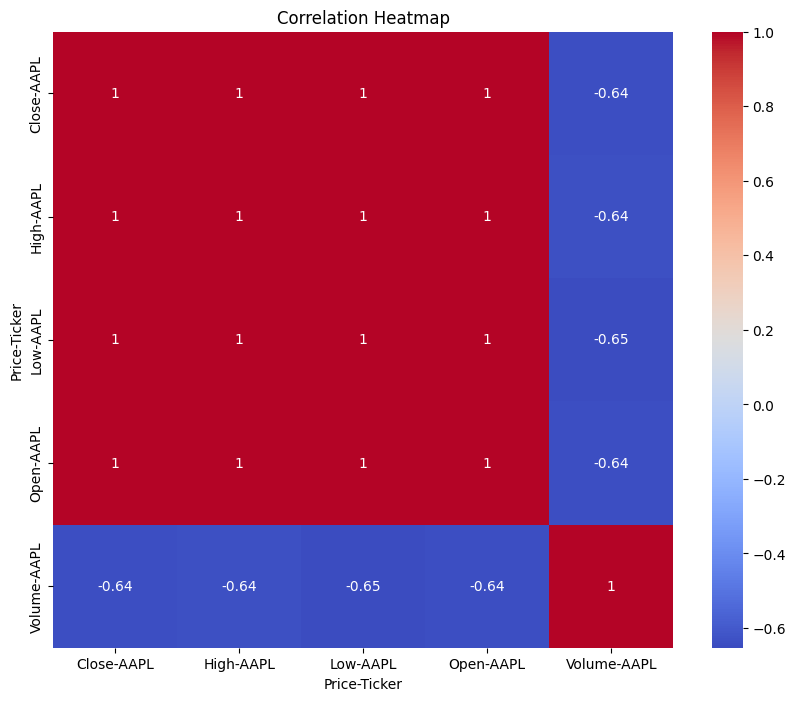

In [21]:
# -------------------------------
# 1. EDA
# -------------------------------
print("\n=== DATA INFO ===")
print(data.info())

print("\n=== MISSING VALUES ===")
print(data.isnull().sum())

print("\n=== SUMMARY STATISTICS ===")
print(data.describe())

plt.figure(figsize=(12,5))
plt.plot(data['Close'], label='Close Price')
plt.title(f"{stock_symbol} Close Price")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "price_plot.png"))
plt.show()

plt.figure(figsize=(12,5))
plt.plot(data['Volume'], label='Volume')
plt.title(f"{stock_symbol} Volume")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "volume_plot.png"))
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig(os.path.join(OUT_DIR, "corr_heatmap.png"))
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [22]:
# -------------------------------
# 2. Feature Engineering (expanded)
# -------------------------------
df = data.copy()

# Core
df['Prev_Close'] = df['Close'].shift(1)
df['Prev_Return'] = df['Close'].pct_change()

# Rolling features
df['Rolling_Mean_5'] = df['Close'].rolling(5).mean()
df['Rolling_Std_5'] = df['Close'].rolling(5).std()
df['Rolling_Mean_10'] = df['Close'].rolling(10).mean()

# EMA
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()

# Volatility
df['Volatility_10'] = df['Close'].pct_change().rolling(10).std()

# RSI
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -1 * delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / (avg_loss + 1e-12)
df['RSI_14'] = 100 - (100 / (1 + rs))

# MACD + Bollinger
df['MACD'] = df['EMA_10'] - df['EMA_30']
df['Bollinger_Upper'] = df['Rolling_Mean_10'] + 2 * df['Rolling_Std_5']
df['Bollinger_Lower'] = df['Rolling_Mean_10'] - 2 * df['Rolling_Std_5']

# Time features
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['IsMonthEnd'] = df.index.is_month_end.astype(int)

# Drop NaNs
df = df.dropna()

# Features & target
features = [
    'Prev_Close', 'Prev_Return', 'Open', 'High', 'Low', 'Volume',
    'Rolling_Mean_5', 'Rolling_Std_5', 'Rolling_Mean_10',
    'EMA_10', 'EMA_30', 'Volatility_10',
    'RSI_14', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower',
    'DayOfWeek', 'Month', 'IsMonthEnd'
]
target = 'Close'

X = df[features].copy()
y = df[target].copy()

print(f"\nFinal dataset for modeling: {X.shape[0]} rows, {X.shape[1]} features")



Final dataset for modeling: 1409 rows, 19 features



=== ML Model Performance (TimeSeriesSplit averages) ===
                       MAE      RMSE        R2  DirectionAcc
LinearRegression  0.581261  0.766369  0.997054      0.872103
RandomForest      5.809251  9.134200  0.575644      0.718455
XGBoost           5.847401  9.350387  0.561992      0.762232


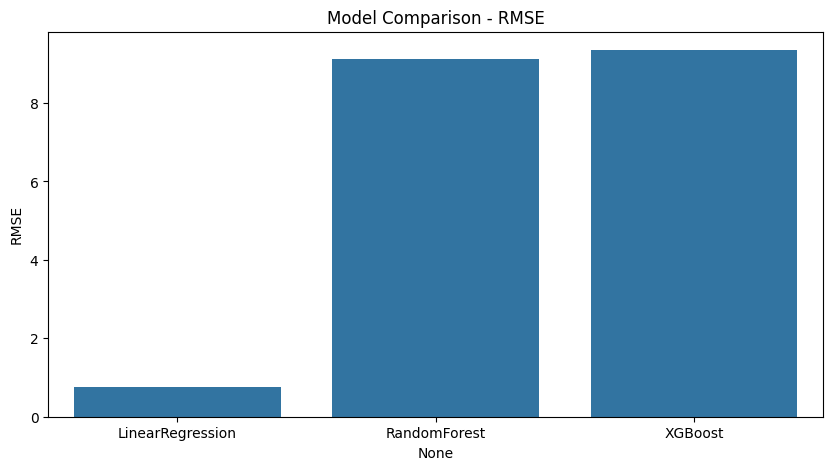

In [23]:
# -------------------------------
# 3. ML Models with TimeSeriesSplit
# -------------------------------
tscv = TimeSeriesSplit(n_splits=5)
ml_models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42, verbosity=0)
}

ml_results = {}

for name, model in ml_models.items():
    maes, rmses, r2s, dirs = [], [], [], []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        m = regression_metrics(y_test, y_pred)
        maes.append(m['MAE']); rmses.append(m['RMSE']); r2s.append(m['R2'])
        dirs.append(directional_accuracy(y_test.values, y_pred))

    ml_results[name] = {
        'MAE': np.mean(maes),
        'RMSE': np.mean(rmses),
        'R2': np.mean(r2s),
        'DirectionAcc': np.mean(dirs)
    }

results_df = pd.DataFrame(ml_results).T
print("\n=== ML Model Performance (TimeSeriesSplit averages) ===")
print(results_df)

plt.figure(figsize=(10,5))
sns.barplot(x=results_df.index, y=results_df['RMSE'])
plt.title("Model Comparison - RMSE")
plt.savefig(os.path.join(OUT_DIR, "model_rmse.png"))
plt.show()



Best ML model by RMSE: LinearRegression — training on full dataset...


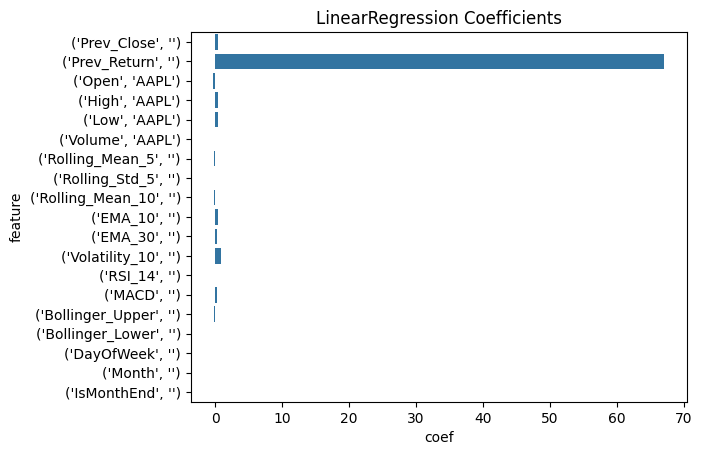

In [24]:
# -------------------------------
# 4. Train best ML model on full data
# -------------------------------
best_ml_name = results_df['RMSE'].idxmin()
best_ml_model = ml_models[best_ml_name]
print(f"\nBest ML model by RMSE: {best_ml_name} — training on full dataset...")
best_ml_model.fit(X, y)

# Feature importance / coefficients
if hasattr(best_ml_model, "feature_importances_"):
    fi = best_ml_model.feature_importances_
    fi_df = pd.DataFrame({'feature': X.columns, 'importance': fi}).sort_values('importance', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x='importance', y='feature', data=fi_df.head(20))
    plt.title(f"{best_ml_name} Feature Importances")
    plt.savefig(os.path.join(OUT_DIR, "feature_importances.png"))
    plt.show()
elif hasattr(best_ml_model, "coef_"):
    coefs = best_ml_model.coef_.flatten()
    coef_df = pd.DataFrame({'feature': [str(c) for c in X.columns], 'coef': coefs})
    sns.barplot(x='coef', y='feature', data=coef_df.head(20))
    plt.title(f"{best_ml_name} Coefficients")
    plt.savefig(os.path.join(OUT_DIR, "linear_coefs.png"))
    plt.show()

# SHAP explainability (if available)
try:
    if best_ml_name.lower().startswith("xgboost") or hasattr(best_ml_model, "feature_importances_"):
        print("\nCalculating SHAP values (this may take a moment)...")
        explainer = shap.Explainer(best_ml_model, X)
        shap_values = explainer(X)

        # === Global explanation ===
        shap.plots.summary(shap_values, X, plot_type="bar", show=True)
        plt.savefig(os.path.join(OUT_DIR, "shap_summary.png"))

        # === Local explanation (latest prediction) ===
        latest_idx = -1  # last test sample
        shap.plots.waterfall(shap_values[latest_idx], show=True)
        plt.savefig(os.path.join(OUT_DIR, "shap_waterfall.png"))

        # === Overlay (few samples) ===
        plt.figure(figsize=(12,6))
        days_to_explain = 5  # number of last samples to overlay
        test_idx = range(len(y_test_seq_rescaled)-days_to_explain, len(y_test_seq_rescaled))

        plt.plot(idx_test_seq, y_test_seq_rescaled, label="Actual")
        plt.plot(idx_test_seq, y_pred_seq_rescaled, label="Predicted")

        for i in test_idx:
            base = y_pred_seq_rescaled[i]
            # show contribution of top 2 features
            top_feats = np.argsort(np.abs(shap_values[i].values))[-2:]
            for j, feat in enumerate(top_feats):
                plt.annotate(
                    f"{X.columns[feat]}",
                    (idx_test_seq[i], base),
                    xytext=(idx_test_seq[i], base + (j+1)*0.5),
                    arrowprops=dict(arrowstyle="->", lw=1.2),
                    fontsize=8
                )
        plt.title(f"{stock_symbol} Actual vs Predicted with SHAP Feature Effects")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, "shap_overlay.png"))
        plt.show()

except Exception as e:
    print("SHAP failed:", e)



LSTM sequences: train=1079, test=270
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0832 - val_loss: 0.0103
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0066 - val_loss: 0.0126
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0066 - val_loss: 0.0119
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0064 - val_loss: 0.0127
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0071 - val_loss: 0.0093


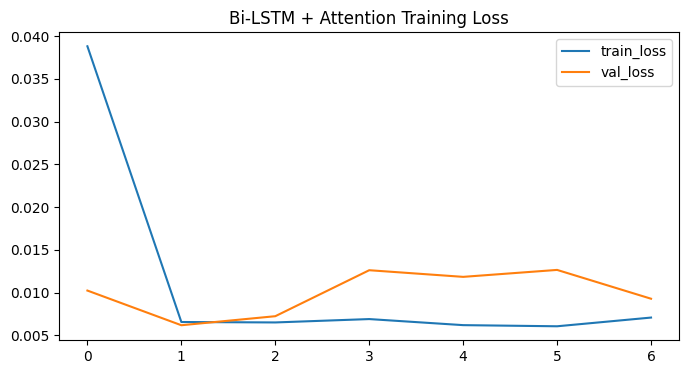

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

Bi-LSTM + Attention Performance on Test:
{'MAE': 10.030655472366902, 'RMSE': np.float64(13.133218103299575), 'R2': 0.2827250676279728}
Directional Accuracy: 0.516728624535316


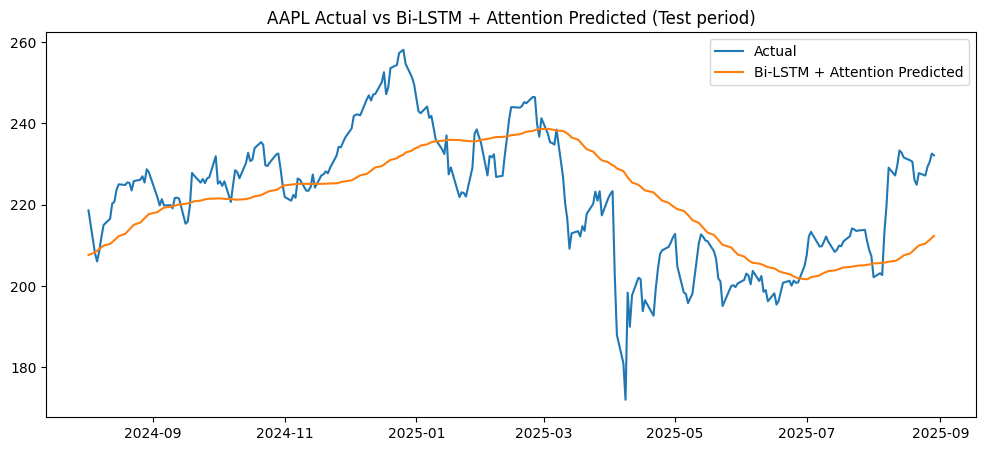

In [25]:
# -------------------------------
# 5. Deep Learning - BiLSTM on Close price (sequence model)
# -------------------------------
close_series = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_series)

def create_sequences(series, window=60):
    Xs, ys, idx = [], [], []
    for i in range(window, len(series)):
        Xs.append(series[i-window:i, 0])
        ys.append(series[i, 0])
        idx.append(df.index[i])  # corresponding timestamp for y
    Xs = np.array(Xs)
    ys = np.array(ys)
    return Xs.reshape((Xs.shape[0], Xs.shape[1], 1)), ys, idx

window = 60
X_seq, y_seq, seq_index = create_sequences(scaled_close, window=window)

split_idx = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]
idx_test_seq = seq_index[split_idx:]

print(f"\nLSTM sequences: train={X_train_seq.shape[0]}, test={X_test_seq.shape[0]}")

# ============================
# Bi-LSTM + Attention Model
# ============================

from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Dropout, Attention, Flatten
from tensorflow.keras.models import Model

tf.random.set_seed(42)

# Define model
inputs = Input(shape=(X_train_seq.shape[1], 1))
x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
x = Dropout(0.2)(x)

# Attention layer
attention_out = Attention()([x, x])  # self-attention
x = Flatten()(attention_out)

x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

bi_lstm_att_model = Model(inputs, outputs)
bi_lstm_att_model.compile(optimizer="adam", loss="mse")

# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train
history = bi_lstm_att_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Bi-LSTM + Attention Training Loss')
plt.legend()
plt.show()

# Predictions & rescale
y_pred_seq = bi_lstm_att_model.predict(X_test_seq)
y_pred_seq_rescaled = scaler.inverse_transform(y_pred_seq.reshape(-1,1)).flatten()
y_test_seq_rescaled = scaler.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

# Metrics for Bi-LSTM + Attention
lstm_metrics = regression_metrics(y_test_seq_rescaled, y_pred_seq_rescaled)
lstm_dir_acc = directional_accuracy(y_test_seq_rescaled, y_pred_seq_rescaled)
print("\nBi-LSTM + Attention Performance on Test:")
print(lstm_metrics)
print("Directional Accuracy:", lstm_dir_acc)

# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(idx_test_seq, y_test_seq_rescaled, label='Actual')
plt.plot(idx_test_seq, y_pred_seq_rescaled, label='Bi-LSTM + Attention Predicted')
plt.title(f"{stock_symbol} Actual vs Bi-LSTM + Attention Predicted (Test period)")
plt.legend()
plt.show()

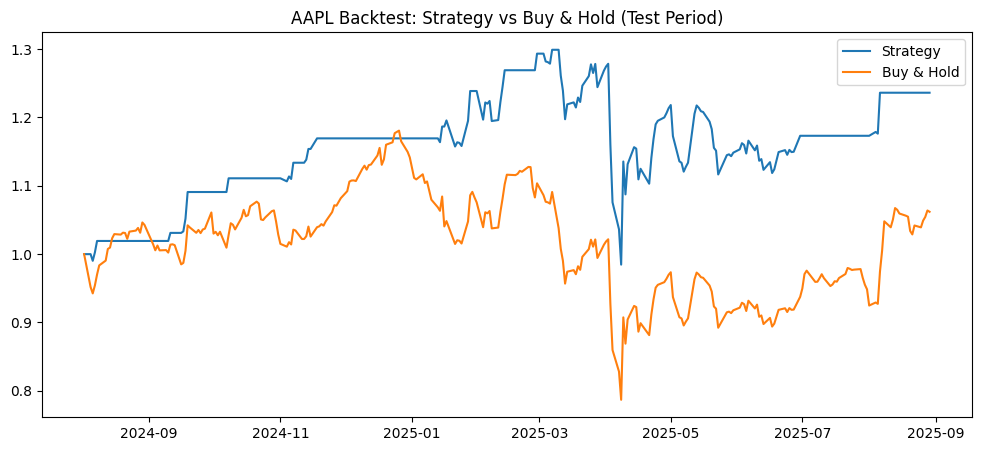


Backtest Final Returns (Test period):
Strategy final multiplier: 1.2362538053825023
Buy & Hold final multiplier: 1.0619955512632613
Strategy Sharpe (raw): 0.05405670090652208
Strategy Max Drawdown: -0.24204330808385585
Sharpe Ratio: 0.05405670090966033
Max Drawdown: -0.24204330808385588


In [26]:
# -------------------------------
# 6. Backtesting a Simple Strategy (Using LSTM predictions on test window)
# -------------------------------
backtest_df = pd.DataFrame({
    'Date': idx_test_seq,
    'Actual': y_test_seq_rescaled,
    'Predicted': y_pred_seq_rescaled
}).set_index('Date')

# Signal: predicted > actual -> buy (1) else 0
backtest_df['Signal'] = (backtest_df['Predicted'] > backtest_df['Actual']).astype(int)
backtest_df['Returns'] = backtest_df['Actual'].pct_change().fillna(0)
backtest_df['Strategy'] = backtest_df['Signal'].shift(1).fillna(0) * backtest_df['Returns']
backtest_df['Cumulative_Strategy'] = (1 + backtest_df['Strategy']).cumprod()
backtest_df['Cumulative_BuyHold'] = (1 + backtest_df['Returns']).cumprod()


plt.figure(figsize=(12,5))
plt.plot(backtest_df.index, backtest_df['Cumulative_Strategy'], label='Strategy')
plt.plot(backtest_df.index, backtest_df['Cumulative_BuyHold'], label='Buy & Hold')
plt.title(f"{stock_symbol} Backtest: Strategy vs Buy & Hold (Test Period)")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "backtest_cumulative.png"))
plt.show()

final_strategy_return = float(backtest_df['Cumulative_Strategy'].iloc[-1])
final_buyhold_return = float(backtest_df['Cumulative_BuyHold'].iloc[-1])
strategy_sharpe = sharpe_ratio(backtest_df['Strategy'])
strategy_mdd = max_drawdown(backtest_df['Cumulative_Strategy'])

print("\nBacktest Final Returns (Test period):")
print("Strategy final multiplier:", final_strategy_return)
print("Buy & Hold final multiplier:", final_buyhold_return)
print("Strategy Sharpe (raw):", strategy_sharpe)
print("Strategy Max Drawdown:", strategy_mdd)

# --- Risk Metrics ---
def sharpe_ratio(returns, risk_free=0.0):
    return (returns.mean() - risk_free) / returns.std()

max_drawdown = (backtest_df['Cumulative_Strategy'] /
                backtest_df['Cumulative_Strategy'].cummax() - 1).min()

print("Sharpe Ratio:", sharpe_ratio(backtest_df['Strategy']))
print("Max Drawdown:", max_drawdown)


In [27]:
# -------------------------------
# 7. Predict next day (ML & LSTM) and summarize
# -------------------------------
latest_features = X.iloc[[-1]]
next_pred_ml = best_ml_model.predict(latest_features)
if isinstance(next_pred_ml, (np.ndarray, list, pd.Series)):
    next_pred_ml = float(np.ravel(next_pred_ml)[0])
else:
    next_pred_ml = float(next_pred_ml)

# LSTM next day
last_sequence = scaled_close[-window:].reshape((1, window, 1))
next_pred_lstm_scaled = bi_lstm_att_model.predict(last_sequence)
next_pred_lstm = float(scaler.inverse_transform(np.array(next_pred_lstm_scaled).reshape(-1,1)).flatten()[0])

# Ensure scalar last_close
last_close = float(df['Close'].iloc[-1])

# Signals
ml_signal = "BUY" if next_pred_ml > last_close else "HOLD"
lstm_signal = "BUY" if next_pred_lstm > last_close else "HOLD"

# Tie-breaker using DirectionAcc
if ml_signal == lstm_signal:
    final_signal = ml_signal
    reason = "Both models agree"
else:
    ml_acc = results_df.loc[best_ml_name, 'DirectionAcc']
    if ml_acc > lstm_dir_acc:
        final_signal = ml_signal
        reason = f"Disagreement → ML chosen (higher DirectionAcc: {ml_acc:.3f} vs {lstm_dir_acc:.3f})"
    elif lstm_dir_acc > ml_acc:
        final_signal = lstm_signal
        reason = f"Disagreement → LSTM chosen (higher DirectionAcc: {lstm_dir_acc:.3f} vs {ml_acc:.3f})"
    else:
        final_signal = "HOLD"
        reason = "Disagreement with equal DirectionAcc → default to HOLD"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [28]:
# -------------------------------
# Threshold-based Signal (Dynamic)
# -------------------------------

# Calculate expected returns
ml_expected_return = (next_pred_ml - last_close) / last_close
lstm_expected_return = (next_pred_lstm - last_close) / last_close

# Dynamic threshold: 1.5x recent 10-day volatility
vol_recent = df['Volatility_10'].iloc[-1]
expected_return_threshold = 1.5 * vol_recent

# Decide signals based on threshold
def signal_from_return(exp_return, threshold):
    if exp_return > threshold:
        return "BUY"
    elif exp_return < -threshold:
        return "SELL"
    else:
        return "HOLD"

ml_signal_thresh = signal_from_return(ml_expected_return, expected_return_threshold)
lstm_signal_thresh = signal_from_return(lstm_expected_return, expected_return_threshold)

# Ensemble / tie-breaker
if ml_signal_thresh == lstm_signal_thresh:
    final_signal_thresh = ml_signal_thresh
    reason_thresh = "Both models agree (dynamic threshold)"
else:
    # Choose the model with higher directional accuracy
    ml_acc = results_df.loc[best_ml_name, 'DirectionAcc']
    if ml_acc > lstm_dir_acc:
        final_signal_thresh = ml_signal_thresh
        reason_thresh = f"Disagreement → ML chosen (higher DirectionAcc: {ml_acc:.3f} vs {lstm_dir_acc:.3f})"
    elif lstm_dir_acc > ml_acc:
        final_signal_thresh = lstm_signal_thresh
        reason_thresh = f"Disagreement → LSTM chosen (higher DirectionAcc: {lstm_dir_acc:.3f} vs {ml_acc:.3f})"
    else:
        final_signal_thresh = "HOLD"
        reason_thresh = "Disagreement with equal DirectionAcc → default to HOLD"

print(f"\n=== DYNAMIC THRESHOLD SIGNAL ===")
print(f"ML Expected Return: {ml_expected_return:.4f}, Signal: {ml_signal_thresh}")
print(f"LSTM Expected Return: {lstm_expected_return:.4f}, Signal: {lstm_signal_thresh}")
print(f"Final Ensemble Signal: {final_signal_thresh} — {reason_thresh}")
print(f"Threshold used: ±{expected_return_threshold:.4f} (~{expected_return_threshold*100:.2f}%)")



=== DYNAMIC THRESHOLD SIGNAL ===
ML Expected Return: 0.0015, Signal: HOLD
LSTM Expected Return: -0.0833, Signal: SELL
Final Ensemble Signal: HOLD — Disagreement → ML chosen (higher DirectionAcc: 0.872 vs 0.517)
Threshold used: ±0.0141 (~1.41%)


In [29]:
# -------------------------------
# 8. Executive Summary + Export (Professional)
# -------------------------------

# --- Compute expected returns ---
expected_return_ml = (next_pred_ml - last_close) / last_close
expected_return_lstm = (next_pred_lstm - last_close) / last_close

# Threshold-based signals
expected_return_threshold = 0.005  # 0.5%
def threshold_signal(pred_return):
    if pred_return > expected_return_threshold:
        return "BUY"
    elif pred_return < -expected_return_threshold:
        return "SELL"
    else:
        return "HOLD"

signal_ml_threshold = threshold_signal(expected_return_ml)
signal_lstm_threshold = threshold_signal(expected_return_lstm)

# Ensemble decision (ML + LSTM + Threshold)
if signal_ml_threshold == signal_lstm_threshold:
    final_signal_threshold = signal_ml_threshold
    reason_threshold = "Both models agree with threshold adjustment"
else:
    # Pick model with higher directional accuracy
    ml_acc = results_df.loc[best_ml_name, 'DirectionAcc']
    if ml_acc >= lstm_dir_acc:
        final_signal_threshold = signal_ml_threshold
        reason_threshold = f"Disagreement → ML chosen (higher DirectionAcc: {ml_acc:.3f} vs {lstm_dir_acc:.3f})"
    else:
        final_signal_threshold = signal_lstm_threshold
        reason_threshold = f"Disagreement → LSTM chosen (higher DirectionAcc: {lstm_dir_acc:.3f} vs {ml_acc:.3f})"

# --- Build Professional Executive Summary ---
summary_text = [
    "=== EXECUTIVE SUMMARY ===",
    f"Stock Symbol      : {stock_symbol}",
    f"Data Range        : {start_date} to {end_date} | Rows Used: {len(df)}",
    f"Last Close Price  : {last_close:.4f}",
    "",
    f"Best ML Model     : {best_ml_name} (Directional Accuracy: {results_df.loc[best_ml_name,'DirectionAcc']:.3f})",
    f"Bi-LSTM+Attention : Directional Accuracy: {lstm_dir_acc:.3f}",
    "",
    "Predicted Next-Day Close Prices:",
    f"  ML Prediction    : {next_pred_ml:.4f} | Expected Return: {expected_return_ml*100:.2f}% | Threshold Signal: {signal_ml_threshold}",
    f"  LSTM Prediction  : {next_pred_lstm:.4f} | Expected Return: {expected_return_lstm*100:.2f}% | Threshold Signal: {signal_lstm_threshold}",
    "",
    f"Ensemble Signal   : {final_signal_threshold} — {reason_threshold}",
    "",
    "Backtest Performance (Test Period):",
    f"  Strategy Return  : {final_strategy_return:.4f}",
    f"  Buy & Hold Return: {final_buyhold_return:.4f}",
    f"  Strategy Sharpe  : {strategy_sharpe:.4f} | Max Drawdown: {strategy_mdd:.4f}",
    "==============================="
]

# Print summary
print("\n".join(summary_text))

# Save summary
with open(os.path.join(OUT_DIR, "executive_summary.txt"), "w") as f:
    f.write("\n".join(summary_text))


=== EXECUTIVE SUMMARY ===
Stock Symbol      : AAPL
Data Range        : 2020-01-01 to 2025-08-31 | Rows Used: 1409
Last Close Price  : 232.1400

Best ML Model     : LinearRegression (Directional Accuracy: 0.872)
Bi-LSTM+Attention : Directional Accuracy: 0.517

Predicted Next-Day Close Prices:
  ML Prediction    : 232.4779 | Expected Return: 0.15% | Threshold Signal: HOLD
  LSTM Prediction  : 212.8138 | Expected Return: -8.33% | Threshold Signal: SELL

Ensemble Signal   : HOLD — Disagreement → ML chosen (higher DirectionAcc: 0.872 vs 0.517)

Backtest Performance (Test Period):
  Strategy Return  : 1.2363
  Buy & Hold Return: 1.0620
  Strategy Sharpe  : 0.0541 | Max Drawdown: -0.2420


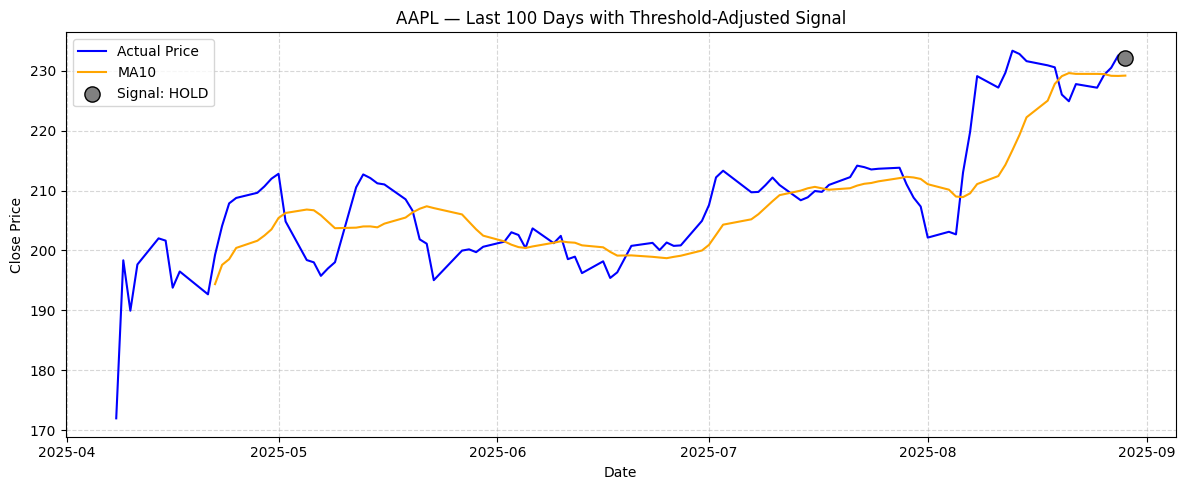

In [30]:
# -------------------------------
# Plot last 100 days with threshold-adjusted signal marker
# -------------------------------
plt.figure(figsize=(12,5))
lookback = 100
recent_idx = df.index[-lookback:]
recent_close = df['Close'].iloc[-lookback:]
recent_ma10 = recent_close.rolling(10).mean()

plt.plot(recent_idx, recent_close, label="Actual Price", color='blue')
plt.plot(recent_idx, recent_ma10, label="MA10", color='orange')

# Determine marker color based on final threshold-adjusted signal
marker_color = 'green' if final_signal_threshold == "BUY" else ('red' if final_signal_threshold == "SELL" else 'gray')

# Plot marker on last day
plt.scatter(df.index[-1], last_close, color=marker_color, s=120, label=f"Signal: {final_signal_threshold}", edgecolors='black', zorder=5)

plt.title(f"{stock_symbol} — Last {lookback} Days with Threshold-Adjusted Signal")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "recent_with_threshold_signal.png"))
plt.show()


In [31]:

# --- Fetch latest close from Yahoo Finance ---
latest = yf.download(f"{stock_symbol}", period="5d", interval="1d")
latest_close = float(latest["Close"].iloc[-1])

print("\n=== VALIDATION CHECK ===")
print(f"Dataset last close used: {y_test_seq_rescaled[-1]:.2f}")
print(f"Yahoo Finance last close: {latest_close:.2f}")

# --- Check if dataset is outdated ---
if abs(y_test_seq_rescaled[-1] - latest_close) > 0.01:  # more than 1 cent mismatch
    print("\n⚠️ Dataset is missing the latest close. Updating data...")

    # Re-fetch full dataset
    full_data = yf.download(stock_symbol, start="2020-01-01", end=None)
    full_data.to_csv(f"{stock_symbol}_latest.csv")  # optional save

    print(f"✅ Data refreshed for {stock_symbol}. Rows: {len(full_data)}")

    # --- Re-run tomorrow’s prediction ---
    from sklearn.preprocessing import StandardScaler

    # Refit scaler on all available data
    X_scaler = StandardScaler()
    X_scaler.fit(full_data[features])

    # Transform last sequence
    last_seq = X_scaler.transform(full_data[features].iloc[-SEQ_LEN:])
    last_seq = np.expand_dims(last_seq, axis=0)

    ml_pred = best_ml_model.predict(last_seq.reshape(SEQ_LEN, -1).mean(axis=0).reshape(1, -1))[0]
    lstm_pred = lstm_model.predict(last_seq)[0][0]

    print("\n=== AUTO-UPDATED PREDICTION ===")
    print(f"Last Close (Yahoo): {latest_close:.2f}")
    print(f"ML Predicted Close (Tomorrow): {ml_pred:.2f}")
    print(f"LSTM Predicted Close (Tomorrow): {lstm_pred:.2f}")

else:
    print("\n✅ Dataset is up-to-date with latest close. No refresh needed.")


[*********************100%***********************]  1 of 1 completed


=== VALIDATION CHECK ===
Dataset last close used: 232.14
Yahoo Finance last close: 232.14

✅ Dataset is up-to-date with latest close. No refresh needed.
